In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import subprocess
import shlex
import os

import torch
import numpy as np
from matplotlib import pyplot as plt

from mtt.simulator import Simulator
from mtt.sensor import Sensor
from mtt.data import OnlineDataset, generate_data
from mtt.models import Conv2dCoder
from mtt.peaks import find_peaks
from mtt.visualize import plot_mtt
from mtt.utils import ospa

rng = np.random.default_rng()

In [3]:
# load model
model_id = "95634b79"
run_path = !guild ls {model_id}
run_path = run_path[0][:-1]
checkpoint_path = os.path.join(run_path, "checkpoints/best.ckpt")
model = Conv2dCoder.load_from_checkpoint(checkpoint_path).cuda()

In [4]:
online_dataset = OnlineDataset(n_steps=119, sigma_position=10, length=20, img_size=128, device="cuda")
dataset = list(online_dataset)

In [5]:
x = torch.stack([d[0] for d in dataset], dim=0)
with torch.no_grad():
    pred_img = model(x.cuda()).cpu().numpy()

n = pred_img.shape[0]
width = online_dataset.init_simulator().width
window = online_dataset.init_simulator().window
extent = [-window / 2, window / 2, -window / 2, window / 2]

predictions = []
for i in range(n):
    predictions.append([
        find_peaks(img, width=window)[0] for img in pred_img[i] 
    ])

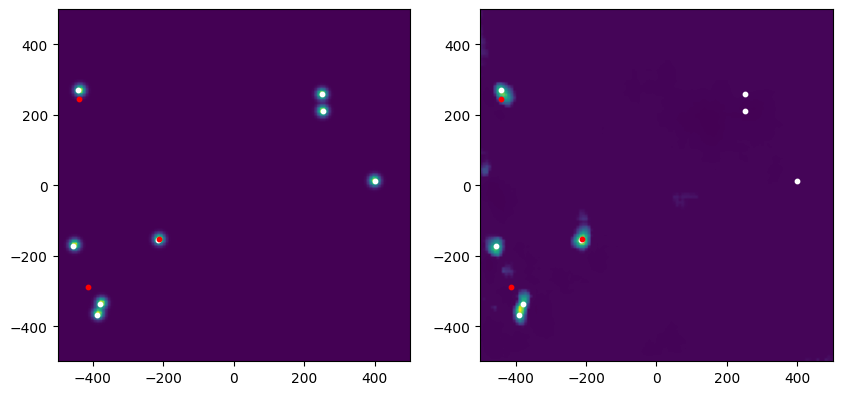

In [6]:
from mtt.peaks import sample_image, fit_gmm
from mtt.utils import gaussian
from matplotlib.patches import Ellipse
from matplotlib import transforms

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

idx = 40
filt_idx = -1


target_pos = dataset[idx][2][filt_idx]["target_positions"]
mus, covs = find_peaks(pred_img[idx][filt_idx], width=window)

axs[0].imshow(dataset[idx][1][filt_idx].cpu(), extent=extent, origin="lower")
axs[1].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower")
for ax in axs:
    ax.scatter(*target_pos.T, c="w", s=10)
    ax.scatter(*mus.T, c="r", s=10)
    ax.set_xlim(-window / 2, window / 2)
    ax.set_ylim(-window / 2, window / 2)
plt.show()

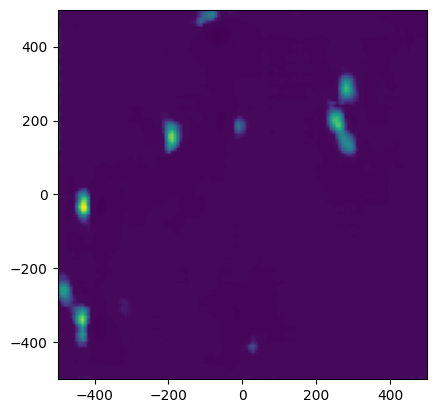

In [7]:
from scipy.ndimage import gaussian_filter

image = pred_img[20][filt_idx]
# image = gaussian_filter(image, sigma=1.0)
plt.imshow(image, extent=extent, origin="lower")

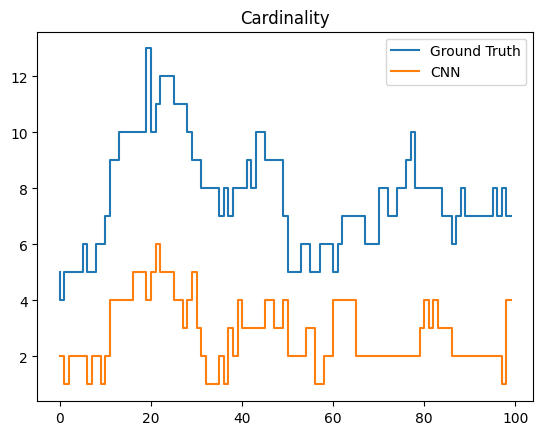

In [8]:
# plot cardinality
filt_idx = -1
card_true = [len(d[2][filt_idx]["target_positions"]) for d in dataset]
card_pred = [len(p[filt_idx]) for p in predictions]

plt.title("Cardinality")
plt.step(np.arange(n), card_true, label="Ground Truth")
plt.step(np.arange(n), card_pred, label="CNN")
plt.legend()
plt.savefig("../figures/cardinality.png")

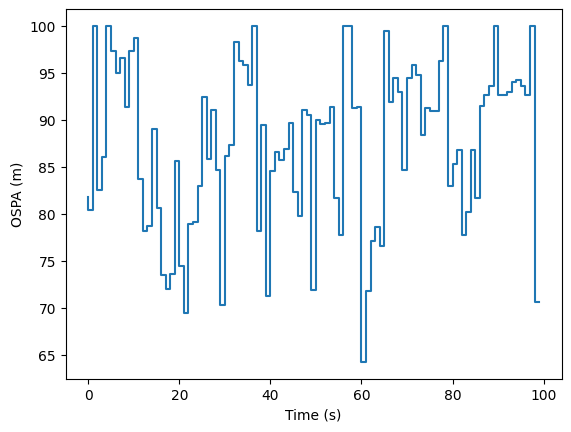

In [9]:
ospas = []
for idx in range(n):
    sensor_img, target_img, info = dataset[idx]
    pred = predictions[idx]
    ospas += [ospa(info[-1]["target_positions"], pred[-1], 100)]
plt.figure()
plt.step(np.arange(n), ospas)
plt.ylabel("OSPA (m)")
plt.xlabel("Time (s)")
plt.savefig("../figures/ospa.png")